In [2]:
import pandas as pd
import numpy as np
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import json
import os
import os.path as op
import mne

# Process the Eyelink .asc file after

After running the edf2asc command line function shipped with the Eyelink developers kit.

In [3]:
subject = 'R1167'
hh = 1 # block number
asc_path = '/Volumes/Server/NEUROLING/Projects/NaturalReading/data/meg/%s/ET/%s_%s.asc' %(subject,subject,hh)

# ignore the response screens for now
relevant_trigs = [1,2,3]

## Read in the .asc file and get each different type of event

In [4]:
f = open(asc_path,'r')
lines = f.readlines()

fixations = [i for i in lines if i.startswith('EFIX')]
saccades = [i for i in lines if i.startswith('ESACC')]
# since recording only around trials, there are very few blinks comarped to
# saccades and fixations
blinks = [i for i in lines if i.startswith('EBLINK')]
# get the triggers
triggers = [i for i in lines if 'MEG Trigger' in i]
# get the stim for each trial
stim_tmp = [i for i in lines if 'IMGLOAD CENTER' in i]
# each image name is the last piece of the stim messages:
# split by slash then by space to get it
stim = [str.split(str.split(ii,'/')[-1],' ')[0] for ii in stim_tmp]


## Let's look at some of these:

In [5]:
fixations[:5]
# End Fix Code, Eye, tStart, tEnd, duration, avgx, avgy, avg pupil size

['EFIX L   681389\t681402\t14\t  470.4\t  308.8\t   1087\n',
 'EFIX L   681409\t681538\t130\t  466.2\t  323.8\t   1076\n',
 'EFIX L   681607\t681782\t176\t   62.2\t  309.5\t   1015\n',
 'EFIX L   681818\t683341\t1524\t  143.7\t  321.0\t   1026\n',
 'EFIX L   683365\t683532\t168\t  197.9\t  321.4\t   1049\n']

## Process the triggers

In [6]:
triggers[:5]

['MSG\t683051 MEG Trigger: 1\n',
 'MSG\t687605 MEG Trigger: 2\n',
 'MSG\t694234 MEG Trigger: 1\n',
 'MSG\t699284 MEG Trigger: 2\n',
 'MSG\t705100 MEG Trigger: 1\n']

In [7]:
# process the triggers
trigtime, code = [],[]
for event in triggers:
    itmp = int(str.split(event.replace('\t', ' '),' ')[-1][0])
    if itmp in relevant_trigs:
        trigtime.append(int(str.split(event.replace('\t', ' '),' ')[1]))
        code.append(int(str.split(event.replace('\t', ' '),' ')[-1][0]))


In [8]:
trigtime[:5]

[683051, 687605, 694234, 699284, 705100]

In [9]:
code[:5]

[1, 2, 1, 2, 1]

## Process the fixations

In [10]:
# fix_start, fix_end, fix_dur, fx, fy, ps = [], [], [], [], [], []
fixdata = np.zeros((len(fixations),6))
for ii in range(len(fixations)):
    row = fixations[ii]
    # get rid of tabs
    row = row.replace('\t', ' ')
    # check to make sure dimension are stable
    row_split = str.split(row, ' ')
    row = [i for i in row_split if i != '']
    assert len(row) == 8
    row = row[2:]
    row[-1] = row[-1][:-1] # gets rid of new line marker
    # convert to floats
    for kk in range(len(row)):
        row[kk] = float(row[kk])
    fixdata[ii,:] = row

In [11]:
fixdata[:5,:] # now in floats

array([[6.81389e+05, 6.81402e+05, 1.40000e+01, 4.70400e+02, 3.08800e+02,
        1.08700e+03],
       [6.81409e+05, 6.81538e+05, 1.30000e+02, 4.66200e+02, 3.23800e+02,
        1.07600e+03],
       [6.81607e+05, 6.81782e+05, 1.76000e+02, 6.22000e+01, 3.09500e+02,
        1.01500e+03],
       [6.81818e+05, 6.83341e+05, 1.52400e+03, 1.43700e+02, 3.21000e+02,
        1.02600e+03],
       [6.83365e+05, 6.83532e+05, 1.68000e+02, 1.97900e+02, 3.21400e+02,
        1.04900e+03]])

## Process the saccades

In [12]:
# process the saccades
# start, end, dur, startx, starty, endx, endy, ampl, peakveloc
sacdata = np.zeros((len(saccades),9))
for ii in range(len(saccades)):
    row = saccades[ii]
    # get rid of tabs
    row = row.replace('\t', ' ')
    # make sure dims are stable
    row_split = str.split(row, ' ')
    row = [i for i in row_split if i != '']
    assert len(row) == 11
    # now get the data
    row = row[2:] # drop strings at start
    row[-1] = row[-1][:-1] # gets rid of new line marker
    # convert to floats
    for kk in range(len(row)):
        try:
            row[kk] = float(row[kk])
        except:
            # this seems to happen every once in a while, around drift check
            if row[kk] == '.':
                # replace with nan
                row[kk] = np.nan
            else:
                raise NameError('UNUSUAL VALUE in Saccades')
    sacdata[ii,:] = row


## Process the blinks

In [13]:
# process the blinks
blinkdata = np.zeros((len(blinks),2))
for ii in range(len(blinks)):
    row = blinks[ii]
    # get rid of tabs
    row = row.replace('\t', ' ')
    # get start and stop
    row_split = str.split(row, ' ')
    blinkdata[ii,:] = [int(row_split[2]),int(row_split[3])]

## Get some summary info:

In [14]:
print('%s fixations' %np.shape(fixdata)[0])
print('%s saccades' %np.shape(sacdata)[0])
print('%s blinks in %s trials' %(np.shape(blinkdata)[0],len(stim)))

1233 fixations
1175 saccades
81 blinks in 86 trials


Now we have all of the data we need in the objects:
- fixdata
- sacdata
- blinkdata
- trigtime
- code
- stim

# Normally, this is run as one big function:

In [15]:
def process_asc_file(asc_path, relevant_trigs):
    f = open(asc_path,'r')
    lines = f.readlines()

    fixations = [i for i in lines if i.startswith('EFIX')]
    saccades = [i for i in lines if i.startswith('ESACC')]
    # since recording only around trials, there are very few blinks comarped to
    # saccades and fixations
    blinks = [i for i in lines if i.startswith('EBLINK')]
    # get the triggers
    triggers = [i for i in lines if 'MEG Trigger' in i]
    # get the stim for each trial
    stim_tmp = [i for i in lines if 'IMGLOAD CENTER' in i]
    # each image name is the last piece of the stim messages:
    # split by slash then by space to get it
    stim = [str.split(str.split(ii,'/')[-1],' ')[0] for ii in stim_tmp]

    # process the triggers
    trigtime, code = [],[]
    for event in triggers:
        itmp = int(str.split(event.replace('\t', ' '),' ')[-1][0])
        if itmp in relevant_trigs:
            trigtime.append(int(str.split(event.replace('\t', ' '),' ')[1]))
            code.append(int(str.split(event.replace('\t', ' '),' ')[-1][0]))

    # process the fixations
    # fix_start, fix_end, fix_dur, fx, fy, ps = [], [], [], [], [], []
    fixdata = np.zeros((len(fixations),6))
    for ii in range(len(fixations)):
        row = fixations[ii]
        # get rid of tabs
        row = row.replace('\t', ' ')
        # check to make sure dimension are stable
        row_split = str.split(row, ' ')
        row = [i for i in row_split if i != '']
        assert len(row) == 8
        row = row[2:]
        row[-1] = row[-1][:-1] # gets rid of new line marker
        # convert to floats
        for kk in range(len(row)):
            row[kk] = float(row[kk])
        fixdata[ii,:] = row

    # process the saccades
    # start, end, dur, startx, starty, endx, endy, ampl, peakveloc
    sacdata = np.zeros((len(saccades),9))
    for ii in range(len(saccades)):
        row = saccades[ii]
        # get rid of tabs
        row = row.replace('\t', ' ')
        # make sure dims are stable
        row_split = str.split(row, ' ')
        row = [i for i in row_split if i != '']
        assert len(row) == 11
        # now get the data
        row = row[2:] # drop strings at start
        row[-1] = row[-1][:-1] # gets rid of new line marker
        # convert to floats
        for kk in range(len(row)):
            try:
                row[kk] = float(row[kk])
            except:
                # this seems to happen every once in a while, around drift check
                if row[kk] == '.':
                    # replace with nan
                    row[kk] = np.nan
                else:
                    raise NameError('UNUSUAL VALUE in Saccades')
        sacdata[ii,:] = row

    # process the blinks
    blinkdata = np.zeros((len(blinks),2))
    for ii in range(len(blinks)):
        row = blinks[ii]
        # get rid of tabs
        row = row.replace('\t', ' ')
        # get start and stop
        row_split = str.split(row, ' ')
        blinkdata[ii,:] = [int(row_split[2]),int(row_split[3])]

    print('%s fixations' %np.shape(fixdata)[0])
    print('%s saccades' %np.shape(sacdata)[0])
    print('%s blinks in %s trials' %(np.shape(blinkdata)[0],len(stim)))

    # return arrays
    return fixdata, sacdata, blinkdata, trigtime, code, stim


# Run it

In [16]:
asc_path = '/Volumes/Server/NEUROLING/Projects/NaturalReading/data/meg/%s/ET/%s_%s.asc' %(subject,subject,hh)
relevant_trigs = [1,2,3]
fixdata, sacdata, blinkdata, trigtime, code, stim = process_asc_file(asc_path, relevant_trigs)

1233 fixations
1175 saccades
81 blinks in 86 trials


# ----------- NOW PREPARE FOR THE MEG DATA -------------

In [17]:
meg_dir = '/Volumes/Server/NEUROLING/Projects/NaturalReading/data/meg/'
megdir = meg_dir # for posterity

subject = 'R1167'
set = 'A1'
ii = 1

In [18]:
# In this case I'm loading in data that has already been preprocessed
raw = mne.io.read_raw_fif(megdir + subject + '/%s_NaturalReading-%s-clean_meg.fif' %(subject,ii))

Opening raw data file /Volumes/Server/NEUROLING/Projects/NaturalReading/data/meg/R1167/R1167_NaturalReading-1-clean_meg.fif...
    Range : 0 ... 490000 =      0.000 ...   490.000 secs
Ready.


In [20]:
# find events
events = mne.find_events(raw)

##### TRIGGER INFORMATION
# Context Sentence, Pre send = 128
# Context Sentence, Post send = 64
# Target Sentence, Pre send = 32
# Target Sentence, Post send = 16
# Third Sentence, Pre send = 8
# Third Sentence, Post send = 4

from collections import Counter
Counter(events[:,2])

172 events found
Event IDs: [  4   8  16  32  64 128]


Counter({128: 36, 64: 36, 32: 36, 16: 36, 8: 14, 4: 14})

In [21]:
## FOR NOW: Look at the context sentences
events = events[events[:,2] == 64]

In [22]:
#  load in the eyelink data for this subject
asc_path = '/Volumes/Server/NEUROLING/Projects/NaturalReading/data/meg/%s/ET/%s_%s.asc' %(subject,subject,hh)

# ignore the response screens
relevant_trigs = [1,2,3]

# assume that the ET data have been preprocessed:
fixdata, sacdata, blinkdata, trigtime, code, stim = process_asc_file(asc_path, relevant_trigs)

1233 fixations
1175 saccades
81 blinks in 86 trials


# Get the Trial Level Data

So far, we have generated huge arrays that contain the fixation, saccades, and blinks for ALL the data. We want to break this into epochs, based on the timing of our triggers.

## Let's start with the very first trial

In [23]:
# We will turn this into a function below, so I'll list all of the args:
tn = 1
set = 'A1' # specific for my exp.
Block = 1
subject = 'R1167'
fixdata = fixdata
sacdata = sacdata
blinkdata = blinkdata
trigtime = trigtime
code = code
stim = stim
sdir = '/Volumes/Server/NEUROLING/Projects/NaturalReading/'
draw_saccades = False
corrected = False

In [24]:
# relevant fixations: start is 1st col, end is 2nd col
fix_sub = fixdata[fixdata[:, 0] > trigtime[tn],:]
# if its not the last trial, also sub by onset of the next one
if tn != len(trigtime)-1:
    fix_sub = fix_sub[fix_sub[:, 1] < trigtime[tn+1],:]

In [25]:
# relevant saccades: start is 1st col, end is 2nd col
sac_sub = sacdata[sacdata[:,0] > trigtime[tn],:]
if tn != len(trigtime)-1:
    sac_sub = sac_sub[sac_sub[:,1] < trigtime[tn+1],:]


In [26]:
# relevant blinks
blink_sub = blinkdata[blinkdata[:,0] > trigtime[tn],:]
if tn != len(trigtime)-1:
    blink_sub = blinkdata[blinkdata[:,1] < trigtime[tn+1],:]


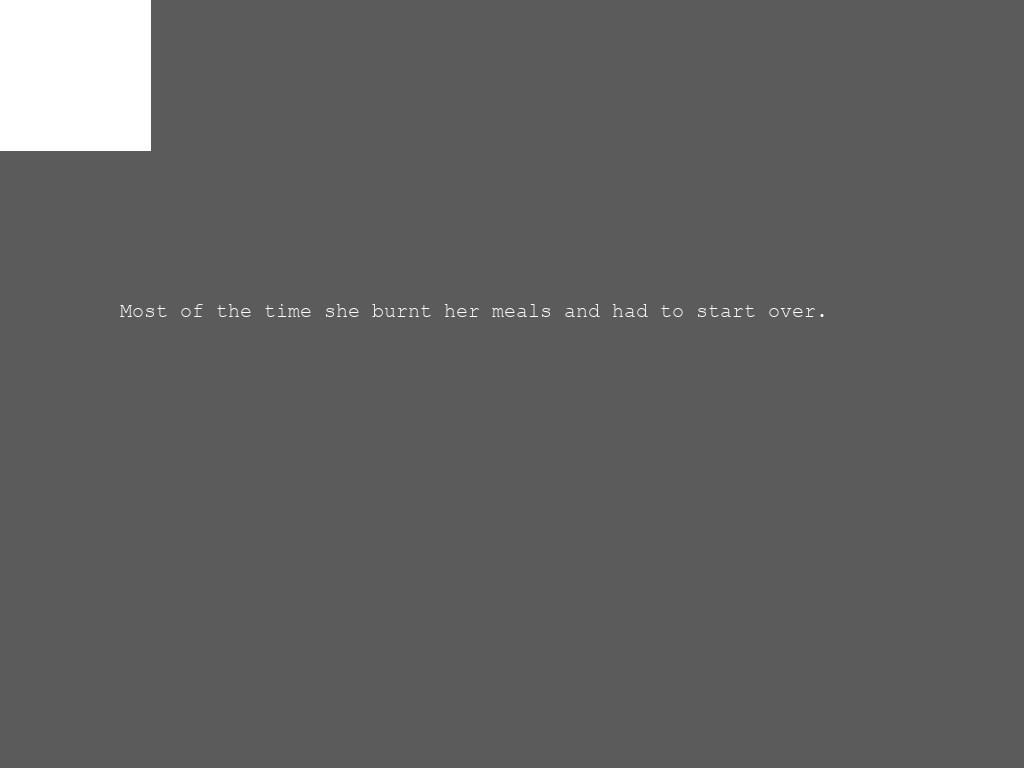

In [27]:
# load the image for this trial
img = Image.open(sdir + 'matlab/STIMULI/images/%s/%s' %(set,stim[tn][:-1]))
myfont = ImageFont.truetype('Courier New',20)
draw = ImageDraw.Draw(img)
display(img)

In [28]:
# draw the fixations as numbered list
for ii in range(len(fix_sub)):
    # x pos, y pos, anchor (la = left ascender, lb = left baseline, mb = middle baseline
    draw.text((fix_sub[ii,3], fix_sub[ii,4]), '%s' %ii, anchor='mb', font=myfont)
    draw.ellipse(xy = [(fix_sub[ii,3]-5,fix_sub[ii,4]-5), (fix_sub[ii,3]+5,fix_sub[ii,4]+5)], outline='red')


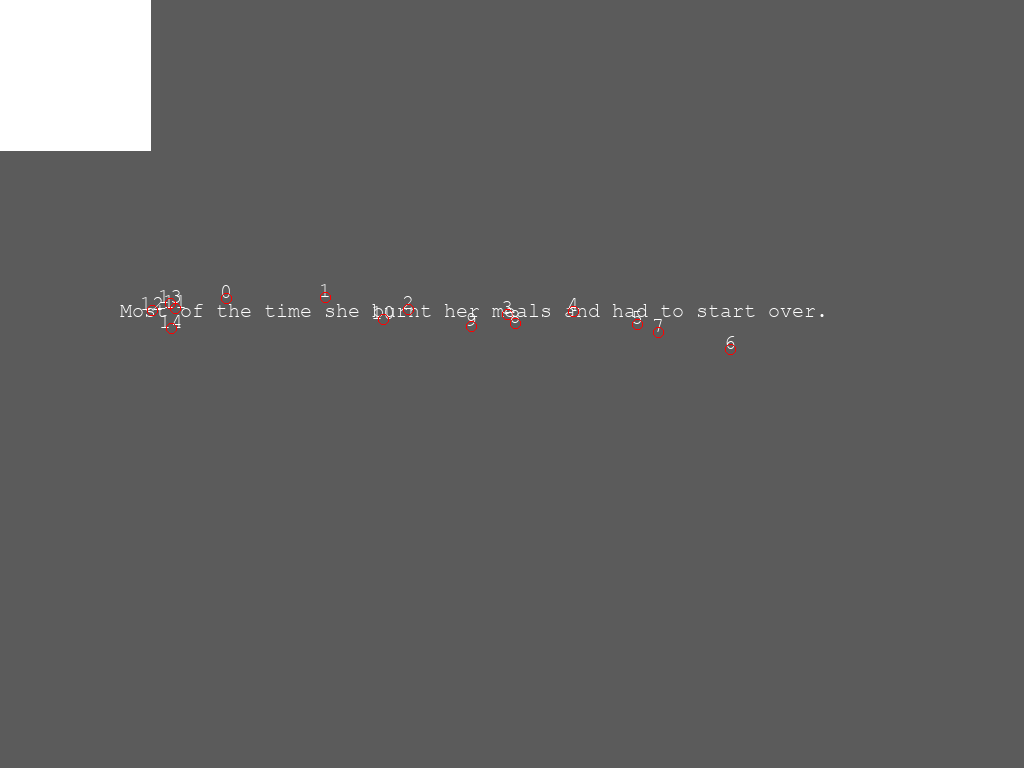

In [29]:
display(img)

In [ ]:
# save it: fixations only
# img.save(sdir + 'data/ET/%s/images/%s_wfix.png' %(subject,stim[tn][:-1]))

This format isn't the most informative, so instead we can make a .gif to show sequence of fixations. Note, however, that the timing here doesn't reflect the actual duration of indiviual saccades. It only shows the order and position.

In [30]:
images = []
for ii in range(len(fix_sub)):
    # load in the image w.o. fixations on it
    img = Image.open(sdir + 'matlab/STIMULI/images/%s/%s' %(set,stim[tn][:-1]))
    myfont = ImageFont.truetype('Courier New',20)
    # draw it
    draw = ImageDraw.Draw(img)
    # add a number indicating this fixation's position
    draw.text((fix_sub[ii,3], fix_sub[ii,4]), '%s' %ii, anchor='mb', font=myfont)
    # put an ellipse there as well to make it clearer
    draw.ellipse(xy = [(fix_sub[ii,3]-5,fix_sub[ii,4]-5), (fix_sub[ii,3]+5,fix_sub[ii,4]+5)], outline='red')
    # append the image to a list that we will make into a gif below
    images.append(img)
# save the list of images as a gif
img.save(sdir + 'data/ET/%s/gifs/%s_%s.gif' %(subject,tn,stim[tn][:-1]), save_all=True, append_images = images,optimize=False,duration=400)

# Define the first fixations on each words (work in progress)

In [31]:
# load in the dictionary of bounding boxes for this trial's stimulus
coords = json.load(open(sdir + 'matlab/STIMULI/coords/%s/%s_json' %(set,stim[tn][:-1]))) # need to use stim[tn] bc the order isn't the same
print(coords)


{'0_Most': [120, 174.0, 275, 342], '1_of': [174.0, 210.0, 275, 342], '2_the': [210.0, 258.0, 275, 342], '3_time': [258.0, 318.0, 275, 342], '4_she': [318.0, 366.0, 275, 342], '5_burnt': [366.0, 438.0, 275, 342], '6_her': [438.0, 486.0, 275, 342], '7_meals': [486.0, 558.0, 275, 342], '8_and': [558.0, 606.0, 275, 342], '9_had': [606.0, 654.0, 275, 342], '10_to': [654.0, 690.0, 275, 342], '11_start': [690.0, 762.0, 275, 342], '12_over.': [762.0, 834.0, 275, 342]}


## MAIN LOOP OVER WORDS IN THE STIMULUS #
This loop will go through each word, get its bounding box, then loop through each fixation to check if:
1. The fixation is inside that word's bounding box
2. That word has not yet been fixated
3. There is no blink that occurs just (500 ms) before the fixation (grounds for exclusion)
4. The previous fixation was to the left of the current one
5. The previous fixation was within the y-bounds of hte line, not coming from way above or below
IF all of these things are TRUE, the fixation gets counted in the dictinoary of first fixations

In [32]:
# initialize a dictinoary that will be filled with the fixation data
data_dict = {}

# get first fixations on each word
for word in coords.keys():

    # get bounding box: x0,x1,y0,y1
    bounding_box = coords[word]

    # find fixations inside the box:
    for ll in range(len(fix_sub)):
        fixation = fix_sub[ll]

        # want dim 3 and 4 for each fixatino: the avg x and y

        # if the fixation is in the x-range:
        if bounding_box[0] < fixation[3] < bounding_box[1]:

            # if the fixation is in the y range:
            if bounding_box[2] < fixation[4] < bounding_box[3]:

                # check if there are any blinks immediately before or after it
                # threshold is 500 ms right now
                bthres = 500
                if not np.any(np.abs(blinkdata[:,1] - fixation[0]) < bthres):

                    #### NOTE: THIS ELIMINATES SECOND LINE FIXATIONS - FIX

                    # now need to make sure its from a left exit:
                    # if it's not hte first one:
                    if ll != 0:
                        prev_fix = fix_sub[ll-1]
                        # make sure x pos of last is less than the current:
                        if fixation[3] > prev_fix[3]:
                            # and it's in the y-range for the line:
                            if bounding_box[2] < prev_fix[4] < bounding_box[3]:

                                # then, if this word is not in the dict already...
                                if not word in data_dict:
                                    # add it
                                    tmp = list(fixation) # convert to list so json can save it
                                    tmp.insert(0, ll) # add total fixation counter
                                    data_dict[word] = tmp
                    else:
                        # first fixations on the sentnece can go past prev fix check
                        # then, if this word is not in the dict already...
                        if not word in data_dict:
                            # add it
                            tmp = list(fixation) # convert to list so json can save it
                            tmp.insert(0, ll) # add total fixation counter
                            data_dict[word] = tmp


In [33]:
data_dict

{'0_Most': [14, 692576.0, 692881.0, 306.0, 171.5, 328.1, 1114.0],
 '2_the': [0, 687950.0, 688133.0, 184.0, 226.6, 298.1, 951.0],
 '4_she': [1, 688159.0, 688310.0, 152.0, 325.7, 297.4, 899.0],
 '5_burnt': [2, 688335.0, 688538.0, 204.0, 408.6, 309.3, 890.0],
 '7_meals': [3, 688335.0, 688915.0, 581.0, 507.3, 314.3, 860.0],
 '8_and': [4, 688948.0, 689099.0, 152.0, 573.5, 311.1, 816.0],
 '9_had': [5, 689129.0, 689323.0, 195.0, 637.1, 324.4, 836.0]}

In [34]:
# Fill in unfixated words if there are any:
for word in coords.keys():
    if word not in data_dict:
        data_dict[word] = 'NoFirstFix'
        
# and add an entry for the start time of the trial
data_dict['__TrialStart'] = trigtime[tn]

In [35]:
data_dict

{'0_Most': [14, 692576.0, 692881.0, 306.0, 171.5, 328.1, 1114.0],
 '2_the': [0, 687950.0, 688133.0, 184.0, 226.6, 298.1, 951.0],
 '4_she': [1, 688159.0, 688310.0, 152.0, 325.7, 297.4, 899.0],
 '5_burnt': [2, 688335.0, 688538.0, 204.0, 408.6, 309.3, 890.0],
 '7_meals': [3, 688335.0, 688915.0, 581.0, 507.3, 314.3, 860.0],
 '8_and': [4, 688948.0, 689099.0, 152.0, 573.5, 311.1, 816.0],
 '9_had': [5, 689129.0, 689323.0, 195.0, 637.1, 324.4, 836.0],
 '1_of': 'NoFirstFix',
 '3_time': 'NoFirstFix',
 '6_her': 'NoFirstFix',
 '10_to': 'NoFirstFix',
 '11_start': 'NoFirstFix',
 '12_over.': 'NoFirstFix',
 '__TrialStart': 687605}

In [36]:
# save the dictionary
# fixation entries are: fix_start, fix_end, fix_dur, fx, fy, ps
if not op.exists(sdir + 'data/ET/%s/json/Block%s/' %(subject,Block)):
    os.makedirs(sdir + 'data/ET/%s/json/Block%s/' %(subject,Block))
json.dump(data_dict, open(sdir+ 'data/ET/%s/json/Block%s/%s_FirstFix' %(subject, Block,stim[tn][:-1]), "w"))

# Make a Function that can do all this for us

In [40]:
def process_trial(tn, set, Block, subject, fixdata, sacdata, blinkdata, trigtime, code, stim, sdir, draw_saccades = False, corrected = True):

    # if ignore this part for now:
    if not corrected:

        # old code: get the arrays from the fixdata, rather than loading them

        # relevant fixations: start is 1st col, end is 2nd col
        fix_sub = fixdata[fixdata[:, 0] > trigtime[tn],:]
        # if its not the last trial, also sub by onset of the next one
        if tn != len(trigtime)-1:
            fix_sub = fix_sub[fix_sub[:, 1] < trigtime[tn+1],:]

        # relevant saccades: start is 1st col, end is 2nd col
        sac_sub = sacdata[sacdata[:,0] > trigtime[tn],:]
        if tn != len(trigtime)-1:
            sac_sub = sac_sub[sac_sub[:,1] < trigtime[tn+1],:]

        # relevant blinks
        blink_sub = blinkdata[blinkdata[:,0] > trigtime[tn],:]
        if tn != len(trigtime)-1:
            blink_sub = blinkdata[blinkdata[:,1] < trigtime[tn+1],:]

        # load the image for this trial
        img = Image.open(sdir + 'matlab/STIMULI/images/%s/%s' %(set,stim[tn][:-1]))
        myfont = ImageFont.truetype('Courier New',20)
        draw = ImageDraw.Draw(img)

        # draw the fixations as numbered list
        for ii in range(len(fix_sub)):
            # x pos, y pos, anchor (la = left ascender, lb = left baseline, mb = middle baseline
            draw.text((fix_sub[ii,3], fix_sub[ii,4]), '%s' %ii, anchor='mb', font=myfont)
            draw.ellipse(xy = [(fix_sub[ii,3]-5,fix_sub[ii,4]-5), (fix_sub[ii,3]+5,fix_sub[ii,4]+5)], outline='red')

        # save it: fixations only
        #img.save(sdir + 'data/ET/%s/images/%s_wfix.png' %(subject,stim[tn][:-1]))

        if make_gif == True:
            images = []
            for ii in range(len(fix_sub)):
                img = Image.open(sdir + 'matlab/STIMULI/images/%s/%s' %(set,stim[tn][:-1]))
                myfont = ImageFont.truetype('Courier New',20)
                draw = ImageDraw.Draw(img)
                draw.text((fix_sub[ii,3], fix_sub[ii,4]), '%s' %ii, anchor='mb', font=myfont)
                #draw.point((fix_sub[ii,3], fix_sub[ii,4]),'red')
                draw.ellipse(xy = [(fix_sub[ii,3]-5,fix_sub[ii,4]-5), (fix_sub[ii,3]+5,fix_sub[ii,4]+5)], outline='red')
                images.append(img)
            img.save(sdir + 'data/ET/%s/gifs/%s_%s.gif' %(subject,tn,stim[tn][:-1]), save_all=True, append_images = images,optimize=False,duration=400)
            # img.save('/Users/gf57/Desktop/out.gif', save_all=True, append_images = images,optimize=False,duration=400)

        if draw_saccades == True:
            # draw the saccades: red lines
            for ii in range(len(sac_sub)):
                draw.line([(int(sac_sub[ii,3]),int(sac_sub[ii,4])),(int(sac_sub[ii,5]),int(sac_sub[ii,6]))], fill='red', width = 0)

            # save it: fixations ane saccades
            subject = 'pilot'
            img.save(sdir + 'data/ET/%s/images/%s_wfix_sac.png' %(subject,stim[tn][:-1]))

    else:
        fix_sub = np.load(sdir + 'data/ET/%s/arrays/Block%s/corrected/Fix_%s_cor.npy' %(subject,Block,stim[tn][:-1]))

    # load in the dictionary of bounding boxes
    coords = json.load(open(sdir + 'matlab/STIMULI/coords/%s/%s_json' %(set,stim[tn][:-1]))) # need to use stim[tn] bc the order isn't the same

    data_dict = {}
    #count = 0 # count of first fixations across all words in sentence
    # get first fixations on each word
    for word in coords.keys():
        # get bounding box: x0,x1,y0,y1
        bounding_box = coords[word]
        # find fixations inside the box:
        for ll in range(len(fix_sub)):
            fixation = fix_sub[ll]
            #print(ll, fixation)

            # want dim 3 and 4 for each fixatino: the avg x and y

            # if the fixation is in the x-range:
            if bounding_box[0] < fixation[3] < bounding_box[1]:

                # if the fixation is in the y range:
                if bounding_box[2] < fixation[4] < bounding_box[3]:

                    # check if there are any blinks immediately before or after it
                    # threshold is 500 ms right now
                    bthres = 500
                    if not np.any(np.abs(blinkdata[:,1] - fixation[0]) < bthres):

                        #### NOTE: THIS ELIMINATES SECOND LINE FIXATIONS - FIX

                        # now need to make sure its from a left exit:
                        # if it's not hte first one:
                        if ll != 0:
                            prev_fix = fix_sub[ll-1]
                            # make sure x pos of last is less than the current:
                            if fixation[3] > prev_fix[3]:
                                # and it's in the y-range for the line:
                                if bounding_box[2] < prev_fix[4] < bounding_box[3]:

                                    # then, if this word is not in the dict already...
                                    if not word in data_dict:
                                        # add it
                                        tmp = list(fixation) # convert to list so json can save it
                                        #tmp.insert(0, count) # add count marker of 1st fixations
                                        tmp.insert(0, ll) # add total fixation counter
                                        data_dict[word] = tmp
                                        #count += 1
                        else:
                            # first fixations on the sentnece can go past prev fix check
                            # then, if this word is not in the dict already...
                            if not word in data_dict:
                                # add it
                                tmp = list(fixation) # convert to list so json can save it
                                #tmp.insert(0, count) # add count marker of 1st fixations - doesn't make sense if looping over word first
                                tmp.insert(0, ll) # add total fixation counter
                                data_dict[word] = tmp
                                #count += 1


    #fill in the unfixated words:
    for word in coords.keys():
        if word not in data_dict:
            data_dict[word] = 'NoFirstFix'
    # add trial start time
    data_dict['__TrialStart'] = trigtime[tn]

    # save the dictionary
    # fixation entries are: fix_start, fix_end, fix_dur, fx, fy, ps
    if not op.exists(sdir + 'data/ET/%s/json/Block%s/' %(subject,Block)):
        os.makedirs(sdir + 'data/ET/%s/json/Block%s/' %(subject,Block))
    json.dump(data_dict, open(sdir+ 'data/ET/%s/json/Block%s/%s_FirstFix' %(subject, Block,stim[tn][:-1]), "w"))

    return data_dict

# ------- NOW WE RETURN TO THE MEG DATA -------- 

In [41]:
# We have a list of events:
print(events[:5,:])
print(len(events))

[[38931     0    64]
 [50113     0    64]
 [60979     0    64]
 [72661     0    64]
 [82427     0    64]]
36


In [42]:
#  load in the eyelink data for this subject
asc_path = '/Volumes/Server/NEUROLING/Projects/NaturalReading/data/meg/%s/ET/%s_%s.asc' %(subject,subject,hh)

# ignore the response screens
relevant_trigs = [1,2,3]

# assume that the ET data have been preprocessed:
fixdata, sacdata, blinkdata, trigtime, code, stim = process_asc_file(asc_path, relevant_trigs)

# get the trial level data
trials =  []
rel_stims = []
Block = hh
make_gif = True
for tn in range(len(stim)):
    if stim[tn].startswith('%s_C' %set):
        trial_data =  process_trial(tn, set, Block, subject, fixdata, sacdata, blinkdata, trigtime, code, stim, sdir, draw_saccades = False, corrected = False)
        trials.append(trial_data)
        rel_stims.append(stim[tn])


1233 fixations
1175 saccades
81 blinks in 86 trials


In [43]:
print(len(trials))
print(len(events))

36
36


In [44]:
# make sure same number of trials and events
if len(trials) != len(events):
    # likely late start to MEG recording
    diff = len(trials) - len(events)
    trials = trials[diff:]
assert len(trials) == len(events)

In [45]:
## now we make the new events array
new_events = []
bads = []
fixdurs = []
for ee in range(len(events)):
    event = events[ee]
    startTime = event[0] #start time in MEG record
    ET_trial = trials[ee]
    etstrt = ET_trial['__TrialStart'] #start time in eyee tracker record
    vals = list(ET_trial.values())
    # now we loop through the first fixations to make new times
    for vv in range(len(vals)-1):
        # ignore last 1 bc its start time
        if type(vals[vv]) == list: # if its a fixation list
            from_start = vals[vv][1] - etstrt #get time from ET start signal
            new_events.append([int(startTime + from_start)]) # add that to the MEG trigger time
            fixdurs.append(vals[vv][3])
    # check the identical times:
    fixes = [val for val in vals if type(val) == list]
    time_ii = [po[1] for po in fixes]
    if not len(np.unique(time_ii)) == len(time_ii):
        #print('Duplicate Event')
        #print(trials[ee].keys())
        #print(vals)
        for ti in time_ii:
            bads.append(1)
    else:
        for ti in time_ii:
            bads.append(0)


In [46]:
# THIS IS A WEIRD PROBLEM: For some reason, the .asc files have some fixations that have identical start times.
# This makes those fixations pretty much unusable. It is actually quite problematic, affecting sometimes ~20% of total 
# fixations. I am meaning to contact SR Research about it. 

# remove the ones with duplicate fixation times: two liners and some glitches
badsidx = np.invert(np.asarray(bads,dtype=bool))

In [47]:
tofill = np.zeros((len(new_events),3))
for rr in range(len(tofill)):
    row = tofill[rr,:]
    row[0] = new_events[rr][0]
    row[2] = 1

new_events = tofill.astype(int)
print('%s out of %s events removed: %s ' %(sum(bads),len(new_events),sum(bads)/len(new_events)))
# remove bads
new_events = new_events[badsidx]


45 out of 204 events removed: 0.22058823529411764 


In [48]:
len(new_events)

159

# MAKE EPOCHS

In [49]:
picks = mne.pick_types(raw.info, meg=True, eeg=False, stim=False)
epochs = mne.Epochs(raw, new_events, event_id = dict(fix=1), tmin=-0.1, tmax=0.4, baseline=None, picks = picks, reject = None)
# epochs.save(fname = megdir + subject + '/%s_Context-FirstFixations-%s-epo.fif' %(subject,hh),overwrite=overwrite)

Not setting metadata
Not setting metadata
159 matching events found
No baseline correction applied
0 projection items activated


/var/folders/6p/bj_pqd055tb3cqszpgnvyd9m0000gr/T/ipykernel_85406/3681541989.py:2: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, new_events, event_id = dict(fix=1), tmin=-0.1, tmax=0.4, baseline=None, picks = picks, reject = None)


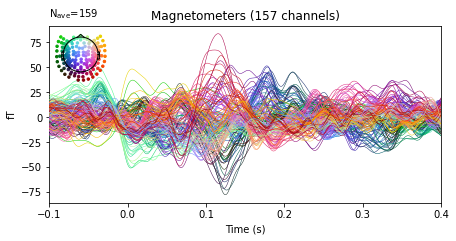

In [50]:
avg = epochs.average()
# look at it and save
fig = avg.plot(picks=picks,spatial_colors=True,show=True)